# Notes

In this notebook, I want to examine the MI between the theta variables conditioned on distance. <br>
The idea is to justify the Dpp upper limit for the state space clustering.

# Imports

In [17]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import time
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib as mpl
import matplotlib.patches as mpatches
import cv2
from pylab import cm
from matplotlib.colors import LogNorm
from scipy.spatial import distance
from scipy.optimize import curve_fit
from scipy.stats import entropy
import seaborn as sns
import os
import sys
%matplotlib widget
%load_ext autoreload
%autoreload 2

# --- import functions for computing kinematic variables --- #
sys.path.append('../../tracking_code/lib/')
sys.path.append('../lib/')

# adding the infomap libs
from infomap_utils import find_binIdxs_for_timeseries
# from infomap_utils import make_dictionary_of_state_numberings, find_binIdxs_for_timeseries
# from infomap_utils import build_transition_matrix, apply_infomap_clustering_to_transition_matrix
# from infomap_utils import make_binTuple_to_clusterIdx_dict
# from post_processing import contiguous_regions
# from post_processing import process_1D_timeseries

from kinematics import compute_pec_pec_distance, compute_thetaW_and_thetaL 
#compute_pitch_angles
# from kinematics import compute_signed_pec_z_difference, compute_phi_dot_from_raw_trajectories, compute_coordinate_origin_z
# from post_processing import contiguous_regions
# from windowed_prob_utils import return_overlapping_windows_for_timeframes, compute_windowed_distribution_array_from_1D_tseries
# from windowed_prob_utils import get_fightbout_rectangle_info


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the tracking data

In [4]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]


with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]

    


# Functions

In [9]:
def compute_MI(Px, Py, Pxy, base=2):
    ''' Compute the Mutual information between the discrete random variables x and y.
    
    -- args --
    Px: the probability state vector for x
    Py: the probability state vector for y
    Pxy: the joint probability state vector for xy (flattened to 1D)
    
    -- returns --
    MI: the mutual information, calculated as 
        I(x;y) = H_X + H_Y - H_XY,
        where H represents the shannon entropy
        
    -- Uses --
    from scipy.stats import entropy
    '''
    H_x = entropy(Px, base=base)
    H_y = entropy(Py, base=base)
    H_xy = entropy(Pxy, base=base)
    MI = H_x + H_y - H_xy
    return MI


def compute_NMI(Px, Py, Pxy, base=2):
    ''' Compute the normalised Mutual information between the discrete
        random variables x and y, using the definition
        NMI = I(x;y) / min( H_x, H_y )
    
    -- args --
    Px: the probability state vector for x
    Py: the probability state vector for y
    Pxy: the joint probability state vector for xy (flattened to 1D)
    
    -- returns --
    NMI: the normalized mutual information, calculated as 
        I(x;y) = (H_X + H_Y - H_XY) /  min( H_x, H_y )
        where H represents the shannon entropy.
        
    -- Uses --
    from scipy.stats import entropy
    '''
    H_x = entropy(Px, base=base)
    H_y = entropy(Py, base=base)
    H_xy = entropy(Pxy, base=base)
    MI = H_x + H_y - H_xy
    norm_fac = np.min( np.array([H_x, H_y]) )
    NMI = MI / norm_fac
    return NMI


def compute_MI_NMI_JSD_from_tettet_tseries(tettet_data, tettet_bins, base=2):
    ''' Compute the Mutual information, the normalized mutual information,
        and then jensen-shannon-divergence of two theta tseries. 
    
    -- args --
    tettet_data: (numFrames,2)
    tettet_bins: bin-edges of discretizing thetas
    base=2: the base for the entropy calculations
    
    -- returns --
    nmi, mi, jsd

    -- see also --
    compute_NMI
    compute_MI
    scipy.spatial.distance.jensenshannon
    '''
    # parse input
    tet1_data = np.copy(tettet_data[:,0])
    tet2_data = np.copy(tettet_data[:,1])
    tet12_data = tettet_data
    
    # calculate the probability vectors, tet_1, tet_2, and tet_12 
    # (excluding NaNs from prob calcs)
    tet1_counts = np.histogram(tet1_data, bins=tettet_bins)[0]
    tet1_probs = tet1_counts / np.sum(tet1_counts)
    tet2_counts = np.histogram(tet2_data, bins=tettet_bins)[0]
    tet2_probs = tet2_counts / np.sum(tet2_counts)
    tet12_counts = np.histogram2d(tet1_data, tet2_data, bins=tettet_bins)[0].reshape(-1) #flatten 2D arr
    tet12_probs = tet12_counts / np.sum(tet12_counts)
    
    # compute the quantities
    nmi = compute_NMI(tet1_probs, tet2_probs, tet12_probs, base=base)
    mi = compute_MI(tet1_probs, tet2_probs, tet12_probs, base=base)
    jsd = ( distance.jensenshannon(tet1_probs, tet2_probs, base=base) )**2
    return nmi, mi, jsd


# Get the kin vars for all experiments

In [14]:
# ---- generate the state variables for all exps ---- #


t0 = time.perf_counter()

exp_dpps = []
exp_tetWs = []
exp_tetLs = []

for ii, expName in enumerate(expNames):
    print(expName)
    
    smooth_traj = smooth_trajectories[ii]
    winIdx = winner_idxs[ii]
    losIdx = loser_idxs[ii]
    
    dpp_ts = compute_pec_pec_distance(smooth_traj)
    tetW_ts, tetL_ts = compute_thetaW_and_thetaL(smooth_traj, winIdx, losIdx)
    
    # ---- record ---- #
    
    exp_dpps.append(dpp_ts)
    exp_tetWs.append(tetW_ts)
    exp_tetLs.append(tetL_ts)
    
tE = time.perf_counter()
print()
print('finished: {0} s'.format(tE-t0))

FishTank20200127_143538
FishTank20200129_140656
FishTank20200130_153857
FishTank20200130_181614
FishTank20200207_161445
FishTank20200213_154940
FishTank20200214_153519
FishTank20200217_160052
FishTank20200218_153008
FishTank20200316_163320
FishTank20200327_154737
FishTank20200330_161100
FishTank20200331_162136
FishTank20200520_152810
FishTank20200521_154541
FishTank20200525_161602
FishTank20200526_160100


/home/liam/code/Dynamics_of_dominance/figures_code/bonus_calculations/../../tracking_code/lib/kinematics.py:24: RuntimeWarning: invalid value encountered in true_divide
  vec_ts = vec_ts / row_norms[:, np.newaxis]


FishTank20200527_152401
FishTank20200824_151740
FishTank20200828_155504
FishTank20200902_160124
FishTank20200903_160946

finished: 9.613228568807244 s


# Prepare bins

In [15]:
# --- prepare the bins --- #

theta_spatial_bins = np.linspace(-np.pi, np.pi, 20)
num_tet_bins = theta_spatial_bins.shape[0] - 1

dpp_bins = np.arange(0, 35+1, 1)
num_dpp_bins = dpp_bins.shape[0] - 1

# a dictionary of names of the dpp bins
bin_dict = dict( zip(np.arange(num_dpp_bins), 
                    ['{0}-{1} cm'.format(dpp_bins[i],dpp_bins[i+1]) for i in range(num_dpp_bins)])
               )

In [16]:
bin_dict

{0: '0-1 cm',
 1: '1-2 cm',
 2: '2-3 cm',
 3: '3-4 cm',
 4: '4-5 cm',
 5: '5-6 cm',
 6: '6-7 cm',
 7: '7-8 cm',
 8: '8-9 cm',
 9: '9-10 cm',
 10: '10-11 cm',
 11: '11-12 cm',
 12: '12-13 cm',
 13: '13-14 cm',
 14: '14-15 cm',
 15: '15-16 cm',
 16: '16-17 cm',
 17: '17-18 cm',
 18: '18-19 cm',
 19: '19-20 cm',
 20: '20-21 cm',
 21: '21-22 cm',
 22: '22-23 cm',
 23: '23-24 cm',
 24: '24-25 cm',
 25: '25-26 cm',
 26: '26-27 cm',
 27: '27-28 cm',
 28: '28-29 cm',
 29: '29-30 cm',
 30: '30-31 cm',
 31: '31-32 cm',
 32: '32-33 cm',
 33: '33-34 cm',
 34: '34-35 cm'}

# Bin the data for the N=18 experiments used in the clustering

In [22]:
chosen_expIdxs = np.unique(fight_bout_info_noDurThresh[:,0])
chosen_expIdxs

array([ 0,  1,  2,  3,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 17, 18, 19,
       20])

In [41]:
chosen_exps_dppBin_tetW_tetL_data = []

for expIdx in chosen_expIdxs:
    #print(expIdx)
    
    # get the data for this exp
    exp_dpp_tseries = exp_dpps[expIdx]
    exp_tetW_tseries = exp_tetWs[expIdx]
    exp_tetL_tseries = exp_tetLs[expIdx]
    
    # make 2D tetW_tetL tseries for ease: shape=(nfs,2)
    exp_tetW_tetL_tseries = np.vstack([exp_tetW_tseries, exp_tetL_tseries]).T
    
    # bin the dpp data
    exp_dpp_bin_Idxs = find_binIdxs_for_timeseries(exp_dpp_tseries, dpp_bins)
    
    # Get the theta-theta data for each dpp bin 
    exp_dppBin_tet_tet_data_list = []
    for i in range(num_dpp_bins):
        bin_tidxs = np.where(exp_dpp_bin_Idxs == i)[0]
        bin_tet_tet_data = np.copy(exp_tetW_tetL_tseries[bin_tidxs])        
        exp_dppBin_tet_tet_data_list.append(bin_tet_tet_data)
        
    # record
    chosen_exps_dppBin_tetW_tetL_data.append(exp_dppBin_tet_tet_data_list)
    

    

# Create shuffled data for control

In each bin, we will randomly permute the tetL tseries.

In [48]:
# ---- create shuffled data, by randomly permuting theta2 for each bin ---- #
np.random.seed(42)


chosen_exps_shuffled_dppBin_tet_tet_data = []

for i,expIdx in enumerate(chosen_expIdxs):
    
    exp_dppBin_tet_tet_data_list = chosen_exps_dppBin_tetW_tetL_data[i]
    
    # for each bin, shuffled theta2
    exp_shuffled_dppBin_tet_tet_data_list = []
    for dppBinIdx in range(len(exp_dppBin_tet_tet_data_list)):
        dppbin_tet1 = exp_dppBin_tet_tet_data_list[dppBinIdx][:,0]
        dppbin_tet2 = exp_dppBin_tet_tet_data_list[dppBinIdx][:,1]
        # create an array of shuffled time indices 
        shuffled_rowidxs = np.arange(dppbin_tet2.shape[0])
        np.random.shuffle(shuffled_rowidxs)
        # grab data in this order
        shuffled_dppbin_tet2 = dppbin_tet2[shuffled_rowidxs]
        # recombine the data
        shuffled_dppbin_tet_tet = np.stack([dppbin_tet1, shuffled_dppbin_tet2], axis=1)
        # record this bin
        exp_shuffled_dppBin_tet_tet_data_list.append(shuffled_dppbin_tet_tet)
        
    # record this experiment
    chosen_exps_shuffled_dppBin_tet_tet_data.append(exp_shuffled_dppBin_tet_tet_data_list)

# Compute the MI(tetW;tetL) for real and control data in each bin

In [92]:
# for every dpp bin, we want to concatenate tet-tet data from all chosen experiments
#trial_nmi_binvals = np.zeros((num_dpp_bins,))

mi_binvals = np.zeros((num_dpp_bins,))
mi_control_binvals = np.zeros((num_dpp_bins,))

# loop over bins
for binIdx in range(num_dpp_bins):
    
    # get the real and control data for this bin
    all_chosen_exp_real_dppbin_tettet_data = np.concatenate([chosen_exps_dppBin_tetW_tetL_data[ii][binIdx] for ii in range(len(chosen_exps_dppBin_tetW_tetL_data))])
    all_chosen_exp_control_dppbin_tettet_data = np.concatenate([chosen_exps_shuffled_dppBin_tet_tet_data[ii][binIdx] for ii in range(len(chosen_exps_shuffled_dppBin_tet_tet_data))])
    
    # get the real and control theta tseries seperately
    tet1_real_data = all_chosen_exp_real_dppbin_tettet_data[:,0]
    tet2_real_data = all_chosen_exp_real_dppbin_tettet_data[:,1]
    tet2_control_data = all_chosen_exp_control_dppbin_tettet_data[:,1]

    # calculate the probability vectors, tet_1, tet_2, and tet_12 (excluding NaNs from prob calcs)
    tet1_real_counts = np.histogram(tet1_real_data, bins=theta_spatial_bins)[0]
    tet1_real_probs = tet1_real_counts / np.sum(tet1_real_counts)
    
    tet2_real_counts = np.histogram(tet2_real_data, bins=theta_spatial_bins)[0]
    tet2_real_probs = tet2_real_counts / np.sum(tet2_real_counts)
    
    tet2_control_counts = np.histogram(tet2_control_data, bins=theta_spatial_bins)[0]
    tet2_control_probs = tet2_control_counts / np.sum(tet2_control_counts)
    
    tet12_real_counts = np.histogram2d(tet1_real_data, tet2_real_data, bins=[theta_spatial_bins,theta_spatial_bins])[0].reshape(-1)
    tet12_real_probs = tet12_real_counts / np.sum(tet12_real_counts)
    
    tet12_control_counts = np.histogram2d(tet1_real_data, tet2_control_data, bins=[theta_spatial_bins,theta_spatial_bins])[0].reshape(-1)
    tet12_control_probs = tet12_control_counts / np.sum(tet12_control_counts)
    
    # compute the normalized mutual information between theta1 and theta2
    mi_binvals[binIdx] = compute_MI(tet1_real_probs, tet2_real_probs, tet12_real_probs)
    mi_control_binvals[binIdx] = compute_MI(tet1_real_probs, tet2_control_probs, tet12_control_probs)

In [93]:
mi_binvals

array([0.30197796, 0.18215283, 0.13700536, 0.10631512, 0.07810173,
       0.06394241, 0.05308181, 0.04555521, 0.03844335, 0.03344552,
       0.02799056, 0.02726159, 0.02123482, 0.02108897, 0.02095667,
       0.01959191, 0.02116505, 0.02459185, 0.02002459, 0.02196377,
       0.019825  , 0.0197853 , 0.03485924, 0.02808497, 0.03655741,
       0.03222655, 0.04003731, 0.03966237, 0.05176564, 0.0581238 ,
       0.07553032, 0.06580692, 0.09905706, 0.10718286, 0.14895579])

In [94]:
mi_control_binvals

array([0.00328381, 0.00160688, 0.00110538, 0.00109268, 0.00048212,
       0.00051363, 0.0007772 , 0.00084186, 0.00104265, 0.00096184,
       0.00081905, 0.00092149, 0.00095953, 0.0010366 , 0.00117626,
       0.00158077, 0.00146371, 0.00149561, 0.00207416, 0.00233277,
       0.00219473, 0.00225558, 0.00256645, 0.00309876, 0.00297035,
       0.00271961, 0.00306673, 0.0040387 , 0.00470833, 0.00522475,
       0.00585395, 0.00655017, 0.01041341, 0.01509122, 0.01828359])

# Plot v1

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
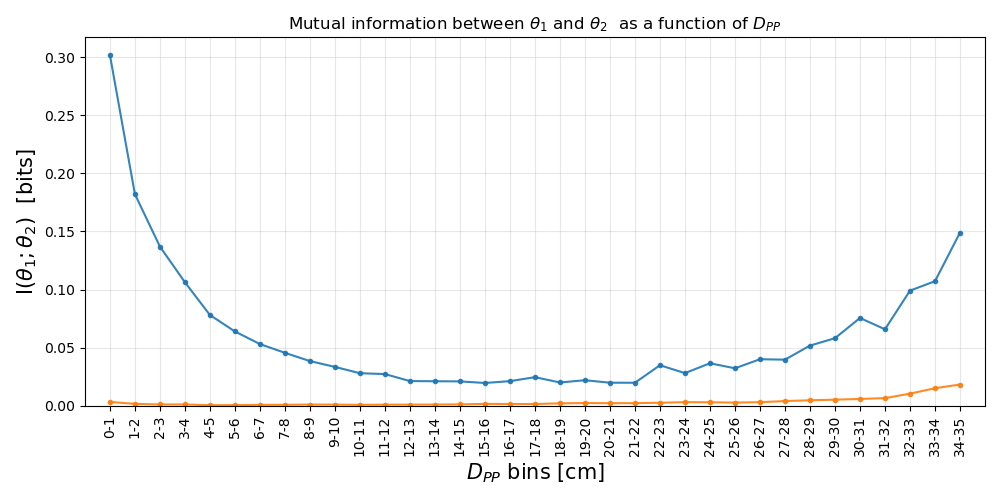

In [101]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = axs

xvals = np.arange(1, num_dpp_bins+1)

ax.set_title('Mutual information between ' + r'$\theta_{1}$ ' + 'and ' r'$\theta_{2}$ ' + ' as a function of ' + r'$D_{PP}$')
ax.plot(xvals,  mi_binvals, color='C0', alpha=0.9, marker='.')
ax.plot(xvals,  mi_control_binvals, color='C1', alpha=0.9, marker='.')

ax.set_xticks(xvals);
ax.set_xticklabels(['{0}-{1}'.format(dpp_bins[i],dpp_bins[i+1]) for i in range(num_dpp_bins)], rotation=90)

ax.grid(alpha=0.3)
ax.set_xlabel(r'$D_{PP}$' + ' bins [cm]', fontsize=15)
ax.set_ylabel(r'$  \mathrm{I} (\theta_{1};\theta_{2})  $'+'  [bits]', fontsize=15)


ax.set_xlim(0, 36)
ax.set_ylim(bottom=0)



fig.tight_layout()

# plot v2

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
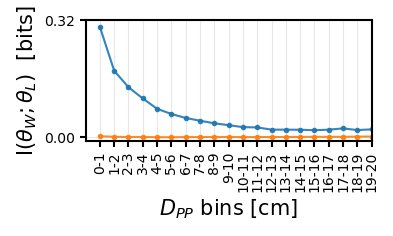

In [134]:

cm = 1/2.54  # centimeters in inches

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10*cm, 6*cm))
ax = axs

xvals = np.arange(1, num_dpp_bins+1)

ax.plot(xvals,  mi_binvals, color='C0', alpha=0.9, marker='.', lw=1.5)
ax.plot(xvals,  mi_control_binvals, color='C1', alpha=0.9, marker='.', lw=1.5)

ax.set_xticks(xvals);
ax.set_xticklabels(['{0}-{1}'.format(dpp_bins[i],dpp_bins[i+1]) for i in range(num_dpp_bins)], rotation=90)

ax.grid(alpha=0.3)
ax.set_xlabel(r'$D_{PP}$' + ' bins [cm]', fontsize=15)
ax.set_ylabel(r'$  \mathrm{I} (\theta_{W};\theta_{L})  $'+'  [bits]', fontsize=15)

ax.set_xlim(0, 20)
ax.set_ylim(bottom=-0.01, top=0.32)

ax.set_yticks([0, 0.32])


ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)


fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/chap3_I_tetW_tetL_on_dpp.png'
#fig.savefig(imsavepath, transparent=True, dpi=900)

In [139]:
((30**2) + (30**2) + (30**2))**0.5

51.96152422706632

# Plot v3

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
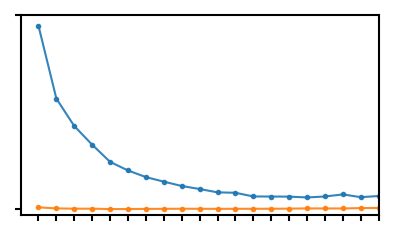

In [136]:
cm = 1/2.54  # centimeters in inches

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10*cm, 6*cm))
ax = axs

xvals = np.arange(1, num_dpp_bins+1)

ax.plot(xvals,  mi_binvals, color='C0', alpha=0.9, marker='.', lw=1.5)
ax.plot(xvals,  mi_control_binvals, color='C1', alpha=0.9, marker='.', lw=1.5)

ax.set_xticks(xvals);
ax.set_xticklabels(['{0}-{1}'.format(dpp_bins[i],dpp_bins[i+1]) for i in range(num_dpp_bins)], rotation=90)

ax.grid(alpha=0.3)
ax.set_xlabel(r'$D_{PP}$' + ' bins [cm]', fontsize=15)
ax.set_ylabel(r'$  \mathrm{I} (\theta_{W};\theta_{L})  $'+'  [bits]', fontsize=15)

ax.set_xlim(0, 20)
ax.set_ylim(bottom=-0.01, top=0.32)

ax.set_yticks([0, 0.32])


ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
    
    
# -------------------- #
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.set_xlabel('');
ax.set_ylabel('');
ax.grid(None)


fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/chap3_I_tetW_tetL_on_dpp.png'
fig.savefig(imsavepath, transparent=True, dpi=900)

# -------------

In [64]:
# ----- load the data for all the experiments ---- #


t0 = time.time()

dpp_exps = []
tets_exps = []

for expIdx in chosen_expIdxs:
    with h5py.File(kin_paths[expIdx], 'r') as hf:
        dpp = hf['pec_pec_distance'][:]
        tet1 = hf['theta_w'][:]
        tet2 = hf['theta_l'][:]
    dpp_exps.append(dpp)
    tets_exps.append(np.stack([tet1, tet2], axis=1))
    

tE = time.time()
print(tE-t0)

0.16264891624450684


In [63]:
# --- prepare the bins --- #

theta_spatial_bins = np.linspace(-np.pi, np.pi, 20)
num_tet_bins = theta_spatial_bins.shape[0] - 1

dpp_bins = np.arange(0, 35+1, 1)
num_dpp_bins = dpp_bins.shape[0] - 1

# a dictionary of names of the dpp bins
bin_dict = dict( zip(np.arange(num_dpp_bins), 
                    ['{0}-{1} cm'.format(dpp_bins[i],dpp_bins[i+1]) for i in range(num_dpp_bins)])
               )

In [35]:
# ------ bin the data for each experiments ------- #

all_exps_dppBin_tet_tet_data = []

for expIdx in range(len(dpp_exps)):
    #print(expIdx)
    
    exp_dpp_tseries = dpp_exps[expIdx]
    exp_tettet_tseries = tets_exps[expIdx]

    # bin dpp
    exp_dpp_bin_Idxs = find_binIdxs_for_timeseries(exp_dpp_tseries, dpp_bins)

    # Get the theta-theta data for each dpp bin 
    exp_dppBin_tet_tet_data_list = []
    for i in range(num_dpp_bins):
        bin_tidxs = np.where(exp_dpp_bin_Idxs == i)[0]
        bin_tet_tet_data = np.copy(exp_tettet_tseries[bin_tidxs])        
        exp_dppBin_tet_tet_data_list.append(bin_tet_tet_data)
        
    # record
    all_exps_dppBin_tet_tet_data.append(exp_dppBin_tet_tet_data_list)

In [65]:
# ---- create shuffled data, by randomly permuting theta2 for each bin ---- #
np.random.seed(42)


all_exps_shuffled_dppBin_tet_tet_data = []

for expIdx in range(len(dpp_exps)):
    
    exp_dppBin_tet_tet_data_list = all_exps_dppBin_tet_tet_data[expIdx]
    
    # for each bin, shuffled theta2
    exp_shuffled_dppBin_tet_tet_data_list = []
    for dppBinIdx in range(len(exp_dppBin_tet_tet_data_list)):
        dppbin_tet1 = exp_dppBin_tet_tet_data_list[dppBinIdx][:,0]
        dppbin_tet2 = exp_dppBin_tet_tet_data_list[dppBinIdx][:,1]
        # create an array of shuffled time indices 
        shuffled_rowidxs = np.arange(dppbin_tet2.shape[0])
        np.random.shuffle(shuffled_rowidxs)
        # grab data in this order
        shuffled_dppbin_tet2 = dppbin_tet2[shuffled_rowidxs]
        # recombine the data
        shuffled_dppbin_tet_tet = np.stack([dppbin_tet1, shuffled_dppbin_tet2], axis=1)
        # record this bin
        exp_shuffled_dppBin_tet_tet_data_list.append(shuffled_dppbin_tet_tet)
        
    # record this experiment
    all_exps_shuffled_dppBin_tet_tet_data.append(exp_shuffled_dppBin_tet_tet_data_list)

In [115]:
# # ---- Bootstrap across experiments for real data experiments ---- #

# t0=time.time()

# savepath = '/mnt/e/dataspace_local/fig4_calcs/real_data.h5'

# # bootstrap parameters
# n_resamples = 50                                      # the number of bootstrap samples   
# numSamples = len(all_exps_dppBin_tet_tet_data)       # the number of things to bootstrap over

# # loop over resamplings
# #resample_bin_nmis = []
# resample_bin_mis = []
# for i in range(n_resamples):
    
#     # select indices of experiments to use
#     indices=np.random.choice(range(0,numSamples), numSamples)
    
#     # for every dpp bin, we want to concatenate tet-tet data from all chosen experiments
#     #trial_nmi_binvals = np.zeros((num_dpp_bins,))
#     trial_mi_binvals = np.zeros((num_dpp_bins,))
#     for binIdx in range(num_dpp_bins):
#         all_trial_exp_dppbin_tettet_data = np.concatenate([all_exps_dppBin_tet_tet_data[expIdx][binIdx] for expIdx in indices])
        
#         tet1_data = all_trial_exp_dppbin_tettet_data[:,0]
#         tet2_data = all_trial_exp_dppbin_tettet_data[:,1]
        
#         # calculate the probability vectors, tet_1, tet_2, and tet_12 (excluding NaNs from prob calcs)
#         tet1_counts = np.histogram(tet1_data, bins=theta_spatial_bins)[0]
#         tet1_probs = tet1_counts / np.sum(tet1_counts)

#         tet2_counts = np.histogram(tet2_data, bins=theta_spatial_bins)[0]
#         tet2_probs = tet2_counts / np.sum(tet2_counts)

#         tet12_counts = np.histogram2d(tet1_data, tet2_data, bins=[theta_spatial_bins,theta_spatial_bins])[0].reshape(-1)
#         tet12_probs = tet12_counts / np.sum(tet12_counts)

#         # compute the normalized mutual information between theta1 and theta2
#         #trial_nmi_binvals[binIdx] = compute_NMI(tet1_probs, tet2_probs, tet12_probs)
#         trial_mi_binvals[binIdx] = compute_MI(tet1_probs, tet2_probs, tet12_probs)
        
#     # record the results for this resample
#     #resample_bin_nmis.append(trial_nmi_binvals)
#     resample_bin_mis.append(trial_mi_binvals)
    
    
# # save
# resample_bin_mis_arr = np.stack(resample_bin_mis, axis=0)
# with h5py.File(savepath, 'w') as hf:
#     hf.create_dataset('resample_bin_mis_arr', data=resample_bin_mis_arr)
    
    
# tE = time.time()
# print(tE-t0)

80.47343564033508


In [116]:
# # ---- Bootstrap across experiments for control data experiments ---- #

# t0=time.time()

# savepath = '/mnt/e/dataspace_local/fig4_calcs/shuffle_data.h5'

# # bootstrap parameters
# n_resamples = 50                                          # the number of bootstrap samples   
# numSamples = len(all_exps_shuffled_dppBin_tet_tet_data)  # the number of things to bootstrap over

# # loop over resamplings
# #resample_bin_nmis = []
# resample_bin_mis = []
# for i in range(n_resamples):
    
#     # select indices of experiments to use
#     indices=np.random.choice(range(0,numSamples), numSamples)
    
#     # for every dpp bin, we want to concatenate tet-tet data from all chosen experiments
#     #trial_nmi_binvals = np.zeros((num_dpp_bins,))
#     trial_mi_binvals = np.zeros((num_dpp_bins,))
#     for binIdx in range(num_dpp_bins):
#         all_trial_exp_dppbin_tettet_data = np.concatenate([all_exps_shuffled_dppBin_tet_tet_data[expIdx][binIdx] for expIdx in indices])
        
#         tet1_data = all_trial_exp_dppbin_tettet_data[:,0]
#         tet2_data = all_trial_exp_dppbin_tettet_data[:,1]
        
#         # calculate the probability vectors, tet_1, tet_2, and tet_12 (excluding NaNs from prob calcs)
#         tet1_counts = np.histogram(tet1_data, bins=theta_spatial_bins)[0]
#         tet1_probs = tet1_counts / np.sum(tet1_counts)

#         tet2_counts = np.histogram(tet2_data, bins=theta_spatial_bins)[0]
#         tet2_probs = tet2_counts / np.sum(tet2_counts)

#         tet12_counts = np.histogram2d(tet1_data, tet2_data, bins=[theta_spatial_bins,theta_spatial_bins])[0].reshape(-1)
#         tet12_probs = tet12_counts / np.sum(tet12_counts)

#         # compute the normalized mutual information between theta1 and theta2
#         #trial_nmi_binvals[binIdx] = compute_NMI(tet1_probs, tet2_probs, tet12_probs)
#         trial_mi_binvals[binIdx] = compute_MI(tet1_probs, tet2_probs, tet12_probs)
        
#     # record the results for this resample
#     #resample_bin_nmis.append(trial_nmi_binvals)
#     resample_bin_mis.append(trial_mi_binvals)
    
    
# # save
# resample_bin_mis_arr = np.stack(resample_bin_mis, axis=0)
# with h5py.File(savepath, 'w') as hf:
#     hf.create_dataset('resample_bin_mis_arr', data=resample_bin_mis_arr)
    
    
# tE = time.time()
# print(tE-t0)

94.17128920555115


In [66]:
# ---- load the real and control data ---- #

real_loadpath = '/mnt/e/dataspace_local/fig4_calcs/real_data.h5'
control_loadpath = '/mnt/e/dataspace_local/fig4_calcs/shuffle_data.h5'

with h5py.File(real_loadpath, 'r') as hf:
    real_resample_bin_mis_arr = hf['resample_bin_mis_arr'][:]
    
with h5py.File(control_loadpath, 'r') as hf:
    control_resample_bin_mis_arr = hf['resample_bin_mis_arr'][:]

In [67]:
# ---- compute the means and stdevs ---- #
real_bootstrap_std = np.std(real_resample_bin_mis_arr, axis=0)
shuffle_bootstrap_std = np.std(control_resample_bin_mis_arr, axis=0)

In [59]:
# ---- compute the MI of the concatenation of all exps --- #


In [68]:
t0 = time.time()

mi_binvals_real = np.zeros((num_dpp_bins,))
mi_binvals_shuffle = np.zeros((num_dpp_bins,))

for binIdx in range(num_dpp_bins):
    # get the real and control data for this bin
    all_exps_dppbin_tettet_data = np.concatenate( [all_exps_dppBin_tet_tet_data[expIdx][binIdx] for expIdx in range(len(all_exps_dppBin_tet_tet_data))] )
    all_exps_shuffle_dppbin_tettet_data = np.concatenate( [all_exps_shuffled_dppBin_tet_tet_data[expIdx][binIdx] for expIdx in range(len(all_exps_shuffled_dppBin_tet_tet_data))] )
    
    # --- real MI --- #
    tet1_data = all_exps_dppbin_tettet_data[:,0]
    tet2_data = all_exps_dppbin_tettet_data[:,1]
    
    # calculate the probability vectors, tet_1, tet_2, and tet_12 (excluding NaNs from prob calcs)
    tet1_counts = np.histogram(tet1_data, bins=theta_spatial_bins)[0]
    tet1_probs = tet1_counts / np.sum(tet1_counts)

    tet2_counts = np.histogram(tet2_data, bins=theta_spatial_bins)[0]
    tet2_probs = tet2_counts / np.sum(tet2_counts)

    tet12_counts = np.histogram2d(tet1_data, tet2_data, bins=[theta_spatial_bins,theta_spatial_bins])[0].reshape(-1)
    tet12_probs = tet12_counts / np.sum(tet12_counts)

    # compute the normalized mutual information between theta1 and theta2
    #trial_nmi_binvals[binIdx] = compute_NMI(tet1_probs, tet2_probs, tet12_probs)
    mi_binvals_real[binIdx] = compute_MI(tet1_probs, tet2_probs, tet12_probs)
    
    
    
    # --- control MI --- #
    tet1_data = all_exps_shuffle_dppbin_tettet_data[:,0]
    tet2_data = all_exps_shuffle_dppbin_tettet_data[:,1]
    
    # calculate the probability vectors, tet_1, tet_2, and tet_12 (excluding NaNs from prob calcs)
    tet1_counts = np.histogram(tet1_data, bins=theta_spatial_bins)[0]
    tet1_probs = tet1_counts / np.sum(tet1_counts)

    tet2_counts = np.histogram(tet2_data, bins=theta_spatial_bins)[0]
    tet2_probs = tet2_counts / np.sum(tet2_counts)

    tet12_counts = np.histogram2d(tet1_data, tet2_data, bins=[theta_spatial_bins,theta_spatial_bins])[0].reshape(-1)
    tet12_probs = tet12_counts / np.sum(tet12_counts)

    # compute the normalized mutual information between theta1 and theta2
    #trial_nmi_binvals[binIdx] = compute_NMI(tet1_probs, tet2_probs, tet12_probs)
    mi_binvals_shuffle[binIdx] = compute_MI(tet1_probs, tet2_probs, tet12_probs)
    
tE = time.time()
print(tE-t0)

3.6646618843078613


In [69]:
mi_binvals_real.shape


(35,)

## first plots

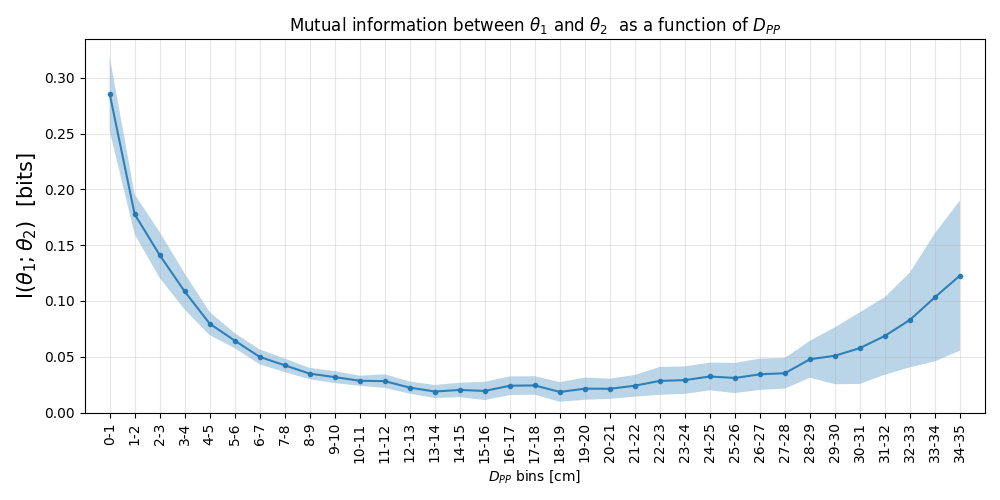

In [70]:

fig, axs = plt.subplots(figsize=(10,5))
ax = axs

xvals = np.arange(1, num_dpp_bins+1)

upper_curve_real = mi_binvals_real + real_bootstrap_std
lower_curve_real = mi_binvals_real - real_bootstrap_std

ax.set_title('Mutual information between ' + r'$\theta_{1}$ ' + 'and ' r'$\theta_{2}$ ' + ' as a function of ' + r'$D_{PP}$')
ax.plot(xvals,  mi_binvals_real, color='C0', alpha=0.9, marker='.')
ax.fill_between(xvals, y1=lower_curve_real, y2=upper_curve_real, alpha=0.3)
ax.set_xlim(0, 36)
ax.set_ylim(bottom=0)
ax.set_xticks(xvals);
ax.set_xticklabels(['{0}-{1}'.format(dpp_bins[i],dpp_bins[i+1]) for i in range(num_dpp_bins)], rotation=90)
ax.set_xlabel(r'$D_{PP}$' + ' bins [cm]')
ax.grid(alpha=0.3)
ax.set_ylabel(r'$  \mathrm{I} (\theta_{1};\theta_{2})  $'+'  [bits]', fontsize=15)


#ax.plot(xvals, mi_binvals_shuffled, color='C1', alpha=0.9, marker='.')

fig.tight_layout()

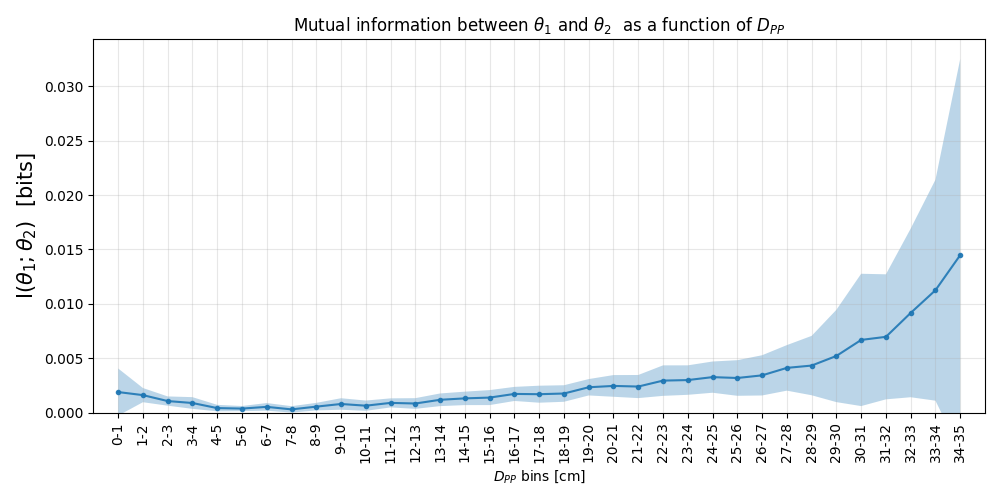

In [71]:
fig, axs = plt.subplots(figsize=(10,5))
ax = axs

xvals = np.arange(1, num_dpp_bins+1)

upper_curve_control = mi_binvals_shuffle + shuffle_bootstrap_std
lower_curve_control = mi_binvals_shuffle - shuffle_bootstrap_std

ax.set_title('Mutual information between ' + r'$\theta_{1}$ ' + 'and ' r'$\theta_{2}$ ' + ' as a function of ' + r'$D_{PP}$')
ax.plot(xvals,  mi_binvals_shuffle, color='C0', alpha=0.9, marker='.')
ax.fill_between(xvals, y1=lower_curve_control, y2=upper_curve_control, alpha=0.3)
ax.set_xlim(0, 36)
ax.set_ylim(bottom=0)
ax.set_xticks(xvals);
ax.set_xticklabels(['{0}-{1}'.format(dpp_bins[i],dpp_bins[i+1]) for i in range(num_dpp_bins)], rotation=90)
ax.set_xlabel(r'$D_{PP}$' + ' bins [cm]')
ax.grid(alpha=0.3)
ax.set_ylabel(r'$  \mathrm{I} (\theta_{1};\theta_{2})  $'+'  [bits]', fontsize=15)


#ax.plot(xvals, mi_binvals_shuffled, color='C1', alpha=0.9, marker='.')

fig.tight_layout()

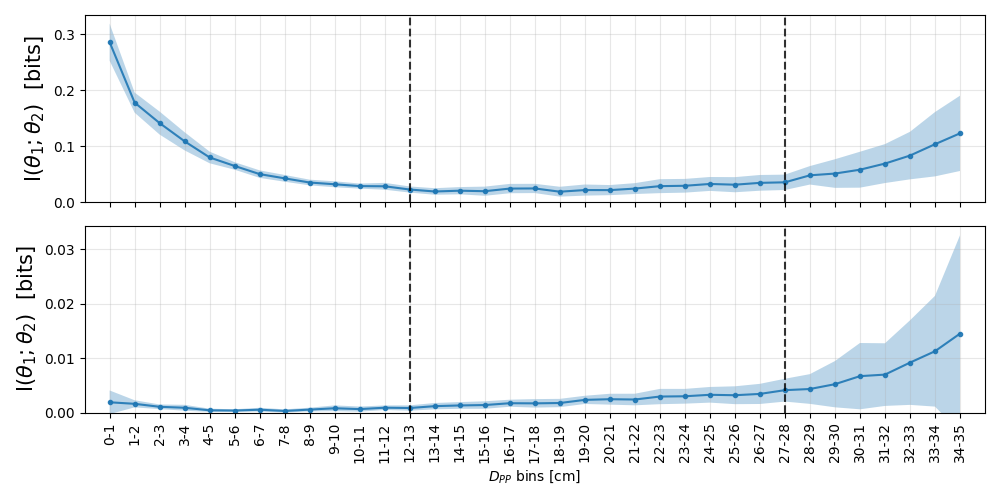

In [72]:

fig, axs = plt.subplots(figsize=(10,5), nrows=2)


# ---------------------------------------#
ax = axs[0]
xvals = np.arange(1, num_dpp_bins+1)

upper_curve_real = mi_binvals_real + real_bootstrap_std
lower_curve_real = mi_binvals_real - real_bootstrap_std

#ax.set_title('Mutual information between ' + r'$\theta_{1}$ ' + 'and ' r'$\theta_{2}$ ' + ' as a function of ' + r'$D_{PP}$')
ax.plot(xvals,  mi_binvals_real, color='C0', alpha=0.9, marker='.')
ax.fill_between(xvals, y1=lower_curve_real, y2=upper_curve_real, alpha=0.3)
ax.set_xlim(0, 36)
ax.set_ylim(bottom=0)
ax.set_xticks(xvals);
ax.set_xticklabels([], rotation=90)
ax.set_xlabel('')
ax.grid(alpha=0.3)
ax.set_ylabel(r'$  \mathrm{I} (\theta_{1};\theta_{2})  $'+'  [bits]', fontsize=15)

ax.axvline(x=13, linestyle='--', color='black', alpha=0.8)
ax.axvline(x=28, linestyle='--', color='black', alpha=0.8)

# ---------------------------------------#
ax = axs[1]
xvals = np.arange(1, num_dpp_bins+1)

upper_curve_control = mi_binvals_shuffle + shuffle_bootstrap_std
lower_curve_control = mi_binvals_shuffle - shuffle_bootstrap_std

#ax.set_title('Mutual information between ' + r'$\theta_{1}$ ' + 'and ' r'$\theta_{2}$ ' + ' as a function of ' + r'$D_{PP}$')
ax.plot(xvals,  mi_binvals_shuffle, color='C0', alpha=0.9, marker='.')
ax.fill_between(xvals, y1=lower_curve_control, y2=upper_curve_control, alpha=0.3)
ax.set_xlim(0, 36)
ax.set_ylim(bottom=0)
ax.set_xticks(xvals);
ax.set_xticklabels(['{0}-{1}'.format(dpp_bins[i],dpp_bins[i+1]) for i in range(num_dpp_bins)], rotation=90)
ax.set_xlabel(r'$D_{PP}$' + ' bins [cm]')
ax.grid(alpha=0.3)
ax.set_ylabel(r'$  \mathrm{I} (\theta_{1};\theta_{2})  $'+'  [bits]', fontsize=15)

ax.axvline(x=13, linestyle='--', color='black', alpha=0.8)
ax.axvline(x=28, linestyle='--', color='black', alpha=0.8)

# ---------------------------------------------------#



# ---------------------------------------#
fig.tight_layout()

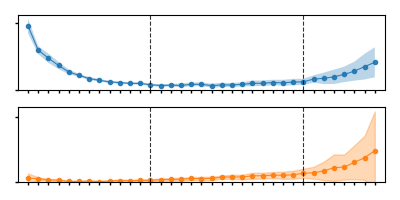

In [73]:

fig, axs = plt.subplots(figsize=(4,2), nrows=2)


# ---------------------------------------#
ax = axs[0]
xvals = np.arange(1, num_dpp_bins+1)

upper_curve_real = mi_binvals_real + real_bootstrap_std
lower_curve_real = mi_binvals_real - real_bootstrap_std

#ax.set_title('Mutual information between ' + r'$\theta_{1}$ ' + 'and ' r'$\theta_{2}$ ' + ' as a function of ' + r'$D_{PP}$')
ax.plot(xvals,  mi_binvals_real, color='C0', alpha=0.9, marker='.', linewidth=0.8)
ax.fill_between(xvals, y1=lower_curve_real, y2=upper_curve_real, alpha=0.3)
ax.set_xlim(0, 36)
ax.set_ylim(bottom=0)
ax.set_xticks(xvals);
ax.set_xticklabels([], rotation=90)
ax.set_xlabel('')
ax.grid(alpha=0.3)
#ax.set_ylabel(r'$  \mathrm{I} (\theta_{1};\theta_{2})  $'+'  [bits]', fontsize=15)
ax.set_yticks([0, 0.3])
ax.set_yticklabels([])

ax.axvline(x=13, linestyle='--', color='black', alpha=0.8, linewidth=0.8)
ax.axvline(x=28, linestyle='--', color='black', alpha=0.8, linewidth=0.8)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.8)
ax.xaxis.set_tick_params(width=1, length=2)
ax.yaxis.set_tick_params(width=1, length=2)
ax.grid(alpha=0.2)

# ---------------------------------------#
ax = axs[1]
xvals = np.arange(1, num_dpp_bins+1)

upper_curve_control = mi_binvals_shuffle + shuffle_bootstrap_std
lower_curve_control = mi_binvals_shuffle - shuffle_bootstrap_std

#ax.set_title('Mutual information between ' + r'$\theta_{1}$ ' + 'and ' r'$\theta_{2}$ ' + ' as a function of ' + r'$D_{PP}$')
ax.plot(xvals,  mi_binvals_shuffle, color='C1', alpha=0.9, marker='.', linewidth=0.8)
ax.fill_between(xvals, y1=lower_curve_control, y2=upper_curve_control, alpha=0.3, color='C1')
ax.set_xlim(0, 36)
ax.set_ylim(bottom=0)
ax.set_xticks(xvals);
ax.set_xticklabels([], rotation=90)
#ax.set_xlabel(r'$D_{PP}$' + ' bins [cm]')
ax.grid(alpha=0.3)
#ax.set_ylabel(r'$  \mathrm{I} (\theta_{1};\theta_{2})  $'+'  [bits]', fontsize=15)
ax.set_yticks([0, 0.03])
ax.set_yticklabels([])

ax.axvline(x=13, linestyle='--', color='black', alpha=0.8, linewidth=0.8)
ax.axvline(x=28, linestyle='--', color='black', alpha=0.8, linewidth=0.8)


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.8)
ax.xaxis.set_tick_params(width=1, length=2)
ax.yaxis.set_tick_params(width=1, length=2)
ax.grid(alpha=0.2)
#ax.legend(fontsize=4, frameon=False, labelspacing=4, bbox_to_anchor=(0.9,0.85))



# ---------------------------------------#


fig.tight_layout()

#fig.savefig('/mnt/e/OneDrive/illustrator_projects/paper_figures/figure4/fig4_B_MI.png', dpi=300, transparent=True)

## main plots

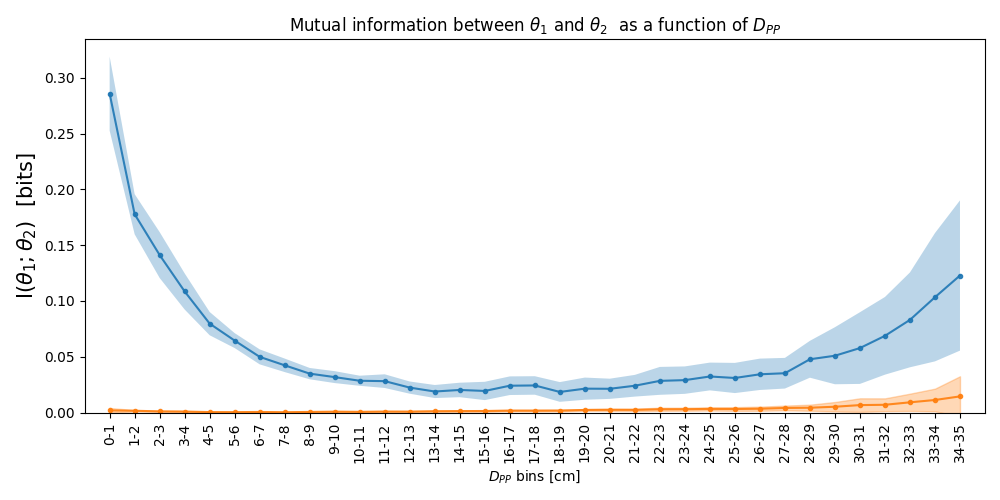

In [74]:

fig, axs = plt.subplots(figsize=(10,5), nrows=1)
ax = axs

# ---------------------------------------#
xvals = np.arange(1, num_dpp_bins+1)

upper_curve_real = mi_binvals_real + real_bootstrap_std
lower_curve_real = mi_binvals_real - real_bootstrap_std

ax.set_title('Mutual information between ' + r'$\theta_{1}$ ' + 'and ' r'$\theta_{2}$ ' + ' as a function of ' + r'$D_{PP}$')
ax.plot(xvals,  mi_binvals_real, color='C0', alpha=0.9, marker='.')
ax.fill_between(xvals, y1=lower_curve_real, y2=upper_curve_real, alpha=0.3)
ax.set_xlim(0, 36)
ax.set_ylim(bottom=0)
ax.set_xticks(xvals);
ax.set_xticklabels(['{0}-{1}'.format(dpp_bins[i],dpp_bins[i+1]) for i in range(num_dpp_bins)], rotation=90)
ax.set_xlabel(r'$D_{PP}$' + ' bins [cm]')
ax.grid(alpha=0.3)
ax.set_ylabel(r'$  \mathrm{I} (\theta_{1};\theta_{2})  $'+'  [bits]', fontsize=15)


# ---------------------------------------#
xvals = np.arange(1, num_dpp_bins+1)

upper_curve_control = mi_binvals_shuffle + shuffle_bootstrap_std
lower_curve_control = mi_binvals_shuffle - shuffle_bootstrap_std


ax.plot(xvals,  mi_binvals_shuffle, color='C1', alpha=0.9, marker='.')
ax.fill_between(xvals, y1=lower_curve_control, y2=upper_curve_control, alpha=0.3,  color='C1')
ax.set_xlim(0, 36)
ax.set_ylim(bottom=0)
ax.set_xticks(xvals);
ax.set_xticklabels(['{0}-{1}'.format(dpp_bins[i],dpp_bins[i+1]) for i in range(num_dpp_bins)], rotation=90)
ax.set_xlabel(r'$D_{PP}$' + ' bins [cm]')
ax.grid(alpha=0.3)
ax.set_ylabel(r'$  \mathrm{I} (\theta_{1};\theta_{2})  $'+'  [bits]', fontsize=15)



# ---------------------------------------#
fig.tight_layout()

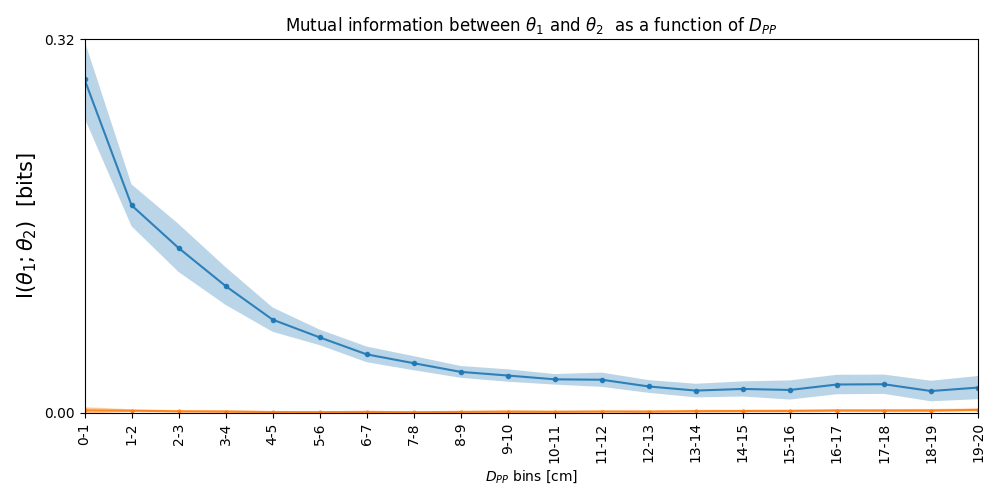

In [91]:

fig, axs = plt.subplots(figsize=(10,5), nrows=1)
ax = axs

# ---------------------------------------#
xvals = np.arange(1, num_dpp_bins+1)

upper_curve_real = mi_binvals_real + real_bootstrap_std
lower_curve_real = mi_binvals_real - real_bootstrap_std

ax.set_title('Mutual information between ' + r'$\theta_{1}$ ' + 'and ' r'$\theta_{2}$ ' + ' as a function of ' + r'$D_{PP}$')
ax.plot(xvals,  mi_binvals_real, color='C0', alpha=0.9, marker='.')
ax.fill_between(xvals, y1=lower_curve_real, y2=upper_curve_real, alpha=0.3)


# ---------------------------------------#
xvals = np.arange(1, num_dpp_bins+1)

upper_curve_control = mi_binvals_shuffle + shuffle_bootstrap_std
lower_curve_control = mi_binvals_shuffle - shuffle_bootstrap_std


ax.plot(xvals,  mi_binvals_shuffle, color='C1', alpha=0.9, marker='.', markersize=4)
ax.fill_between(xvals, y1=lower_curve_control, y2=upper_curve_control, alpha=0.3,  color='C1')

# ---------------------------------------#

ax.set_ylim(bottom=0)
ax.set_xticks(xvals);

yticks = [0, 0.32]
ax.set_yticks(yticks);

ax.set_xticklabels(['{0}-{1}'.format(dpp_bins[i],dpp_bins[i+1]) for i in range(num_dpp_bins)], rotation=90)
ax.set_xlabel(r'$D_{PP}$' + ' bins [cm]')
#ax.grid(alpha=0.3)
ax.set_ylabel(r'$  \mathrm{I} (\theta_{1};\theta_{2})  $'+'  [bits]', fontsize=15)

ax.set_xlim(1, 20)
ax.set_ylim(0, 0.32)

# ---------------------------------------#
fig.tight_layout()

## paper version

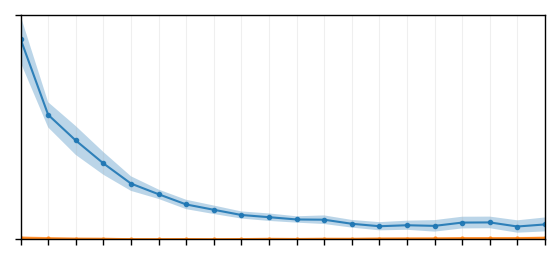

In [107]:
imsavepath = '/mnt/e/OneDrive/illustrator_projects/paper_figures/figure4/panel_B_alt_MI.png'


fig, axs = plt.subplots(figsize=(5.6,2.6), nrows=1)
ax = axs

# ---------------------------------------#
xvals = np.arange(1, num_dpp_bins+1)

upper_curve_real = mi_binvals_real + real_bootstrap_std
lower_curve_real = mi_binvals_real - real_bootstrap_std

ax.set_title('Mutual information between ' + r'$\theta_{1}$ ' + 'and ' r'$\theta_{2}$ ' + ' as a function of ' + r'$D_{PP}$')
ax.plot(xvals,  mi_binvals_real, color='C0', alpha=0.9, marker='.')
ax.fill_between(xvals, y1=lower_curve_real, y2=upper_curve_real, alpha=0.3)


# ---------------------------------------#
xvals = np.arange(1, num_dpp_bins+1)

upper_curve_control = mi_binvals_shuffle + shuffle_bootstrap_std
lower_curve_control = mi_binvals_shuffle - shuffle_bootstrap_std


ax.plot(xvals,  mi_binvals_shuffle, color='C1', alpha=0.9, marker='.', markersize=4)
ax.fill_between(xvals, y1=lower_curve_control, y2=upper_curve_control, alpha=0.3,  color='C1')

# ---------------------------------------#

ax.set_ylim(bottom=0)
ax.set_xticks(xvals);
yticks = [0, 0.32]
ax.set_yticks(yticks);
ax.set_xlim(1, 20)
ax.set_ylim(0, 0.32)


# ---------------------------------------#

ax.set_title('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.grid(alpha=0.2)
ax.set_ylabel('')

lw = 1
ticklen = 4
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)
ax.xaxis.set_tick_params(width=lw, length=ticklen)
ax.yaxis.set_tick_params(width=lw, length=ticklen)

# ---------------------------------------#
fig.tight_layout()

fig.savefig(imsavepath, dpi=300, transparent=False)